# Accessing higher energy states with Qiskit Pulse

In most quantum algorithms/applications, computations are carried out over a 2-dimensional space spanned by $|0\rangle$ and $|1\rangle$. In IBM's hardware, however, there also exist higher energy states which are not typically used. The focus of this section is to explore these states using Qiskit Pulse. In particular, we demonstrate how to excite the $|2\rangle$ state and build a discriminator to classify the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states.

We recommend reviewing the prior [chapter](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html) before going through this notebook. We also suggest reading the Qiskit Pulse specifications (Ref [1](#refs)). 

### Physics Background

We now give some additional background on the physics of transmon qubits, the basis for much of IBM's quantum hardware. These systems contain superconducting circuits composed of a Josephson junction and capacitor. For those unfamiliar with superconducting circuits, see the review [here](https://arxiv.org/pdf/1904.06560.pdf) (Ref. [2](#refs)). The Hamiltonian of this system is given by

$$
H = 4 E_C n^2 - E_J \cos(\phi),
$$

where $E_C, E_J$ denote the capacitor and Josephson energies, $n$ is the reduced charge number operator and $\phi$ is the reduced flux across the junction. We work in units with $\hbar=1$.

Transmon qubits are defined in the regime where $\phi$ is small, so we may expand $E_J \cos(\phi)$ in a Taylor series (ignoring constant terms)

$$
E_J \cos(\phi) \approx \frac{1}{2} E_J \phi^2 - \frac{1}{24} E_J \phi^4 + \mathcal{O}(\phi^6).
$$

The quadratic term $\phi^2$ defines the standard harmonic oscillator. Each additional term contributes an anharmonicity.

Using the relations $n \sim (a-a^\dagger), \phi \sim (a+a^\dagger)$ (for raising, lowering operators $a^\dagger, a$), it can be shown that the system resembles a Duffing oscillator with Hamiltonian
$$
H = \omega a^\dagger a + \frac{\alpha}{2} a^\dagger a^\dagger a a,
$$

where $\omega$ gives the $0\rightarrow1$ excitation frequency ($\omega \equiv \omega^{0\rightarrow1}$) and $\alpha$ is the anharmonicity between the $0\rightarrow1$ and $1\rightarrow2$ frequencies ($\alpha \equiv \omega^{1\rightarrow2} - \omega^{0\rightarrow1}$). Drive terms can be added as needed. 

If we choose to specialize to the standard 2-dimensional subspace, we can make $|\alpha|$ sufficiently large or use special control techniques to suppress the higher energy states.

# Contents

[Getting started](#importing)  
[Discriminating the 0, 1 and 2 states](#discrim012)  
&emsp; [Computing the 1->2 Frequency](#freq12)  
&emsp; [1->2 Rabi Experiment](#rabi12)  
&emsp; [Build the 0, 1, 2 discriminator](#builddiscrim012)  
[References](#refs)  

## Getting Started <a id="importing"></a>

We begin by importing dependencies and defining some default variable values. We choose qubit 0 to run our experiments. We perform our experiments on the publicly available single qubit device `ibmq_armonk`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule

from qiskit.tools.monitor import job_monitor

In [2]:
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_defaults = backend.defaults()

backend_properties = backend.properties()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 0 has an estimated frequency of 4.971611422182356 GHz.
Default anharmonicity is -0.34719293148282626 GHz.


We define some additional helper functions.

In [3]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

Next we include some default parameters for drive pulses. 

In [4]:
# there are pulse parameters of the single qubit drive in ibmq_armonk
x12_duration = 320
x12_sigma = 80

## Discriminating the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states <a id="discrim012"></a> 

given we have already calibrated X gate in the qubit subspace, which is available as XGate instruction in the quantum circuit. Here we calibrate transition in the higher energy subspace with pulse gate.

We focus on exciting the $|2\rangle$ state and building a discriminator to classify $|0\rangle$, $|1\rangle$ and $2\rangle$ states from their respective IQ data points. The procedure for even higher states ($|3\rangle$, $|4\rangle$, etc.) should be similar, but we have not tested them explicitly.

The process for building the higher state discriminator is as follows:
1. Compute the $1\rightarrow2$ frequency.
2. Conduct a Rabi experiment to obtain the $\pi$ pulse amplitude for $1\rightarrow2$. To do this, we first apply a $0\rightarrow1$ $\pi$ pulse to get from the $|0\rangle$ to the $|1\rangle$ state. Then, we do a sweep of drive amplitudes at the $1\rightarrow2$ frequency obtained above.
3. Construct 3 schedules:\
    a. Zero schedule: just measure the ground state.\
    b. One schedule: apply a $0\rightarrow1$ $\pi$ pulse and measure.\
    c. Two schedule: apply a $0\rightarrow1$ $\pi$ pulse, then a $1\rightarrow2$ $\pi$ pulse and measure.
4. Separate the data from each schedule into training and testing sets and construct an LDA model for discrimination.

### Computing the 1->2 frequency <a id="freq12"></a>

The first step in our calibration is to compute the frequency needed to go from the $1\rightarrow2$ state. There are two methods to do this:
1. Do a frequency sweep from the ground state and apply very high power. If the applied power is large enough, two peaks should be observed. One at the $0\rightarrow1$ frequency found in section [1](#discrim01) and one at the $0\rightarrow2$ frequency. The $1\rightarrow2$ frequency can be obtained by taking the difference of the two. Unfortunately, for `ibmq_armonk`, the maximum drive power of $1.0$ is not sufficient to see this transition. Instead, we turn to the second method.
2. Excite the $|1\rangle$ state by applying a $0\rightarrow1$ $\pi$ pulse. Then perform the frequency sweep over excitations of the $|1\rangle$ state. A single peak should be observed at a frequency lower than the $0\rightarrow1$ frequency which corresponds to the $1\rightarrow2$ frequency.

We follow the second method described above. 

In [5]:
# smaller range sweep
num_freqs = 75
drive_power = 0.3
sweep_freqs = default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

In [6]:
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

In [7]:
spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(1, 1)

qc_spect.x(0)
qc_spect.append(spect_gate, [0])
qc_spect.measure(0, 0)
qc_spect.add_calibration(spect_gate, (0,), freq12_sweep_sched, [freq])
    
exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

In [8]:
excited_freq_sweep_job = backend.run(exp_spect_circs, 
                                     meas_level=1, 
                                     meas_return='avg', 
                                     shots=NUM_SHOTS)

In [9]:
job_monitor(excited_freq_sweep_job)

Job Status: job has successfully run


In [10]:
# Get the refined data (average)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

Let's plot and fit the refined signal, using the standard Lorentzian curve.

In [11]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 10000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [12]:
# do fit in Hz
(excited_sweep_fit_params, 
 excited_sweep_y_fit) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.625*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

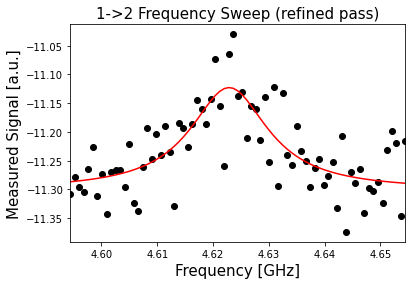

In [13]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [14]:
_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6228688 GHz.


### 1->2 Rabi Experiment  <a id="rabi12"></a>

Now that we have a good estimate for the $1\rightarrow2$ frequency, we perform a Rabi experiment to obtain the $\pi$ pulse amplitude for the $1\rightarrow2$ transition. To do so, we apply a $0\rightarrow1$ $\pi$ pulse and then sweep over drive amplitudes at the $1\rightarrow2$ frequency.

In [15]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [16]:
amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [17]:
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.x(0)
qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]
    

In [18]:
rabi_12_job = backend.run(exp_rabi_circs, 
                          meas_level=1, 
                          meas_return='avg', 
                          shots=NUM_SHOTS)

In [19]:
job_monitor(rabi_12_job)

Job Status: job has successfully run


In [20]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

In [21]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

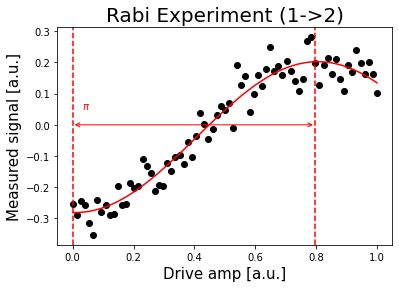

In [22]:
# Note: Only real part of data is plotted
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                               rabi_12_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.2, 0, 0.8, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12 - drive_12_period/2 , color='red', linestyle='--')
plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12 - drive_12_period/2, 0), xytext=(pi_amp_12, 0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12 - drive_12_period/2 + 0.03, 0.05), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()


We plot and fit our data as before.

In [23]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6228688 GHz.
Pi Amplitude (1->2) = 0.7961331672058236


### Build the 0, 1, 2 discriminator <a id="builddiscrim012"></a>

Finally, we build our discriminator for the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states. 

As a review, our three circuits are (again, recalling that our system starts in the $|0\rangle$ state): 
1. Measure the $|0\rangle$ state directly (obtain $|0\rangle$ centroid).
2. Apply $0\rightarrow1$ $\pi$ pulse and then measure (obtain $|1\rangle$ centroid).
3.  Apply $0\rightarrow1$ $\pi$ pulse, then $1\rightarrow2$ $\pi$ pulse, then measure (obtain $|2\rangle$ centroid).

In [24]:
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)

In [25]:
# Create the three circuits

# 0 state
qc_ground = QuantumCircuit(1, 1)
qc_ground.measure(0, 0)

# 1 state
qc_one = QuantumCircuit(1, 1)
qc_one.x(0)
qc_one.measure(0, 0)

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_x12 = QuantumCircuit(1, 1)
qc_x12.x(0)
qc_x12.append(x12_gate, [0])
qc_x12.measure(0, 0)
qc_x12.add_calibration(x12_gate, (0,), x12_sched, [])

We construct the program and plot the centroids in the IQ plane.

In [26]:
# Assemble the schedules into a program
IQ_012_job = backend.run([qc_ground, qc_one, qc_x12], 
                          meas_level=1, 
                          meas_return='single', 
                          shots=NUM_SHOTS)

In [27]:
job_monitor(IQ_012_job)

Job Status: job has successfully run


In [28]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [29]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

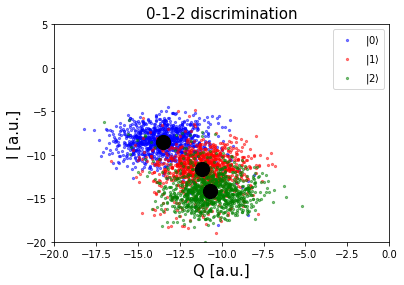

In [30]:
x_min = -20
x_max = 0
y_min = -20
y_max = 5
IQ_012_plot(x_min, x_max, y_min, y_max)

Now it is time to actually build the discriminator. We will use a machine learning technique called Linear Discriminant Analysis (LDA). LDA classifies an arbitrary data set into a set of categories (here $|0\rangle$, $|1\rangle$ and $|2\rangle$) by maximizing the distance between the means of each category and minimizing the variance within each category. For further detail, see [here](https://scikit-learn.org/stable/modules/lda_qda.html#id4) (Ref. [3](#refs)). 

LDA generates a line called a separatrix. Depending on which side of the separatrix a given data point is on, we can determine which category it belongs to. 

We use `scikit.learn` for an implementation of LDA; in a future release, this functionality will be added released directly into Qiskit-Ignis (see  [here](https://github.com/Qiskit/qiskit-ignis/tree/master/qiskit/ignis/measurement/discriminator)). 

We observe a third centroid corresponding to the $|2\rangle$ state. (Note: If the plot looks off, rerun the notebook.)

We begin by reshaping our result data into a format suitable for discrimination. 

In [31]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

We begin by shaping the data for LDA.

In [32]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


Next, we split our training and testing data. The testing data is a vector containing an array of `0`'s (for the zero schedule, `1`'s (for the one schedule) and `2`'s (for the two schedule).

In [33]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

3072


Finally, we set up our model and train it. The accuracy of our fit is printed.

In [34]:
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [35]:
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))

[1. 0. 0.]


In [36]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.814453125


The last step is to plot the separatrix. 

In [37]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

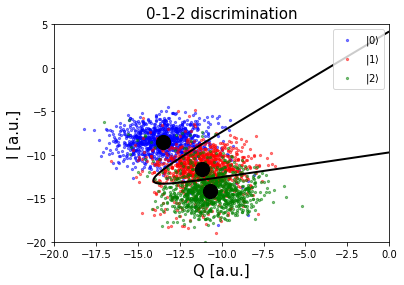

In [38]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

Now that we have 3 centroids, the separatrix is no longer a line, but rather a curve containing a combination of two lines. In order to discriminate between $|0\rangle$, $|1\rangle$ and $|2\rangle$ states, our model checks where the IQ point lies relative to the separatrix and classifies the point accordingly.

## References <a id="refs"></a>

1. D. C. McKay, T. Alexander, L. Bello, M. J. Biercuk, L. Bishop, J. Chen, J. M. Chow, A. D. C ́orcoles, D. Egger, S. Filipp, J. Gomez, M. Hush, A. Javadi-Abhari, D. Moreda, P. Nation, B. Paulovicks, E. Winston, C. J. Wood, J. Wootton, and J. M. Gambetta, “Qiskit backend specifications for OpenQASM and OpenPulse experiments,” 2018, https://arxiv.org/abs/1809.03452.
2. Krantz, P. et al. “A Quantum Engineer’s Guide to Superconducting Qubits.” Applied Physics Reviews 6.2 (2019): 021318, https://arxiv.org/abs/1904.06560.
3. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011, https://scikit-learn.org/stable/modules/lda_qda.html#id4.

In [39]:
import qiskit.tools.jupyter
%qiskit_version_table